# Fitting K412

Using the NeXL libraries, load, plot, fit and report the quantification of a set of K412 spectra.  Loading the <code>Gadfly</code> library adds plotting support to <code>NeXLCore</code> and <code>NeXLSpectrum</code>.  NeXL uses <code>DataFrames</code> 

<div style="text-align: right"> NWMR 20-Nov-2019</div>

In [1]:
using Revise
using NeXLCore
using NeXLSpectrum
using NeXLUncertainties
using Gadfly
using DataFrames

Load the spectra and examine the details in a <code>DataFrame</code>.

In [2]:
path = "K412 spectra"
fe = readEMSA("$(path)/Fe std.msa")
det = matching(fe, 132.0, 10)
unks = (i->readEMSA("$(path)/III-E K412[$i][4].msa",det,true)).(0:4)
al2o3 = readEMSA("$(path)/Al2O3 std.msa",det,true)
caf2 = readEMSA("$(path)/CaF2 std.msa",det,true)
fe = readEMSA("$(path)/Fe std.msa",det,true)
mgo = readEMSA("$(path)/MgO std.msa",det,true)
sio2 = readEMSA("$(path)/SiO2 std.msa",det,true)
asa(DataFrame, Spectrum[unks..., al2o3, caf2, fe, mgo, sio2])

10×8 DataFrame
│ Row │ Name               │ BeamEnergy │ ProbeCurrent │ LiveTime │ RealTime │ Coating                │ Integral  │ Material │
│     │ String             │ Float64⍰   │ Float64⍰     │ Float64⍰ │ Float64⍰ │ Union{Nothing, Film}   │ Float64   │ String⍰  │
├─────┼────────────────────┼────────────┼──────────────┼──────────┼──────────┼────────────────────────┼───────────┼──────────┤
│ 1   │ III-E K412[0][all] │ 20000.0    │ 1.11355      │ 235.484  │ 286.279  │                        │ 8.07948e6 │ K412     │
│ 2   │ III-E K412[1][all] │ 20000.0    │ 1.11355      │ 235.433  │ 286.218  │                        │ 8.07689e6 │ K412     │
│ 3   │ III-E K412[2][all] │ 20000.0    │ 1.11172      │ 235.45   │ 286.278  │                        │ 8.08445e6 │ K412     │
│ 4   │ III-E K412[3][all] │ 20000.0    │ 1.10989      │ 235.441  │ 286.281  │                        │ 8.08681e6 │ K412     │
│ 5   │ III-E K412[4][all] │ 20000.0    │ 1.10989      │ 235.399  │ 286.214  │                        │ 8.08124e6 │ K412     │
│ 6   │ Al2O3 std          │ 20000.0    │ 1.10989      │ 1172.19  │ 1491.48  │ 10.0 nm of Pure Carbon │ 4.9737e7  │ Al2O3    │
│ 7   │ CaF2 std           │ 20000.0    │ 1.10989      │ 1176.1   │ 1456.12  │ 10.0 nm of Pure Carbon │ 4.40595e7 │ CaF2     │
│ 8   │ Fe std             │ 20000.0    │ 1.10989      │ 1171.48  │ 1528.75  │                        │ 5.44487e7 │ Fe       │
│ 9   │ MgO std            │ 20000.0    │ 1.10637      │ 1175.78  │ 1496.02  │ 10.0 nm of Pure Carbon │ 4.98546e7 │ MgO      │
│ 10  │ SiO2 std           │ 20000.0    │ 1.10989      │ 1173.16  │ 1470.35  │ 10.0 nm of Pure Carbon │ 4.66482e7 │ SiO2     │

Plot two of the standard spectra including KLM-lines, escape peaks and coincidences.

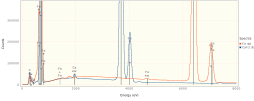

In [3]:
set_default_plot_size(10inch,4inch)
plot([fe, caf2],autoklms=true,yscale=0.2,escapes=[n"Fe K-L3", n"Ca K-L3"], coincidences=[n"Fe L3-M5", n"Fe K-L3"],xmax=8e3)

Plot all the unknowns and place KLMs based on the assigned composition of the spectra.

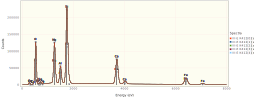

In [4]:
plot(unks,autoklms=true,xmax=8e3)

Build a variable width tophat filter to process the standards and the unknowns.  The detector was constructed by extracting some information from the Fe spectrum and adding additional information (see In[2])

In [5]:
filt = buildfilter(NeXLSpectrum.GaussianFilter,det)

GaussianFilter[EDS[4096 channels, E[ch] = 1.63032 + 9.99856⋅ch, 132.0 eV @ Mn Kα]]

Add the itemes to fit from the standard spectra - primarily characteristic peaks but also escape peaks.  Then process the standards using the <code>charFeature(...)</code> and <code>escapeFeature(...)</code> functions.  Collect the resulting <code>FilteredReference</code> structs into a list.

In [6]:
# Add characteristic peaks 
rr = [
    ( n"O", ktransitions, al2o3 ),
    ( n"Al", ktransitions, al2o3 ),
    ( n"Mg", ktransitions, mgo ),
    ( n"Si", ktransitions, sio2 ),
    ( n"Ca", alltransitions, caf2 ),
    ( n"Fe", alltransitions, fe ),
    ( n"O", ktransitions, al2o3 ),
]
rx = map(r ->(NeXLSpectrum.charFeature(r[1], r[2]), r[3]), rr)

# Add escape peaks
re = [
    ( n"Fe", ( n"K-L3", ), fe )
    ( n"Ca", ( n"K-L3", ), caf2)
]
append!(rx, map(r ->(NeXLSpectrum.escapeFeature(r[1], r[2]), r[3]), re))

refs = collect(Iterators.flatten((r -> filter(r[2], det, r[1], filt, 1.0/dose(r[2]))).(rx)))

12-element Array{FilteredReference,1}:
 Reference[O K-L3 + 1 other]   
 Reference[Al K-L3 + 1 other]  
 Reference[Mg K-L3 + 1 other]  
 Reference[Si K-L3 + 2 others] 
 Reference[Ca L3-M1 + 6 others]
 Reference[Ca K-L3 + 3 others] 
 Reference[Fe L3-M5 + 9 others]
 Reference[Fe K-L3 + 1 other]  
 Reference[Fe K-M3 + 1 other]  
 Reference[O K-L3 + 1 other]   
 Reference[Ecs[Fe K-L3]]       
 Reference[Ecs[Ca K-L3]]       

Use the list of <code>FilteredReference</code> structs to fit all the unknowns returning a list of <code>FilterFitResult</code> objects.  The arguments to fit are the unknown spectrum, the fitting filter (to process the unknown), the standard spectra processed into <code>FilteredReference</code> using the same filter.   The final <code>false</code> argument indicates that while negative k-ratios are removed from the fit, the last (negative) value is retained and returned.

In [7]:
res=(u->fit(u,filt,refs,false)).(unks)

5-element Array{FilterFitResult,1}:
 III-E K412[0][all]
 III-E K412[1][all]
 III-E K412[2][all]
 III-E K412[3][all]
 III-E K412[4][all]

Create a table of the results.  Note "Ecs[Ca K-L3]" is negative.

In [8]:
asa(DataFrame, res)

5×12 DataFrame. Omitted printing of 4 columns
│ Row │ Name               │ Al K-L3 + 1 other │ Ca K-L3 + 3 others │ Ca L3-M1 + 6 others │ Ecs[Ca K-L3] │ Ecs[Fe K-L3] │ Fe K-L3 + 1 other │ Fe K-M3 + 1 other │
│     │ NeXLSpec…          │ Float64           │ Float64            │ Float64             │ Float64      │ Float64      │ Float64           │ Float64           │
├─────┼────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────┼──────────────┼───────────────────┼───────────────────┤
│ 1   │ III-E K412[0][all] │ 0.0678145         │ 0.192529           │ 0.707475            │ -0.0346125   │ 0.0889949    │ 0.0669501         │ 0.0672653         │
│ 2   │ III-E K412[1][all] │ 0.0675364         │ 0.191941           │ 0.703939            │ -0.0498614   │ 0.0819245    │ 0.0671693         │ 0.06785           │
│ 3   │ III-E K412[2][all] │ 0.0679008         │ 0.192558           │ 0.712589            │ -0.0507582   │ 0.0426568    │ 0.0669698         │ 0.0674227         │
│ 4   │ III-E K412[3][all] │ 0.0679746         │ 0.19288            │ 0.708333            │ -0.0261822   │ 0.106279     │ 0.0669294         │ 0.0681977         │
│ 5   │ III-E K412[4][all] │ 0.0680883         │ 0.192506           │ 0.708713            │ -0.0419199   │ 0.0915845    │ 0.0670295         │ 0.0669926         │

Here we reprocess the unknowns but with the final argument <code>true</code>.  Now the returned value for "Esc[Ca K-L3]" is set to zero.  <code>false</code> is the better option if the results from multiple fits are to be averaged to increase the sensitivity for trace elements.

In [9]:
asa(DataFrame, (u->NeXLSpectrum.fit(u,filt,refs,true)).(unks))

5×12 DataFrame. Omitted printing of 4 columns
│ Row │ Name               │ Al K-L3 + 1 other │ Ca K-L3 + 3 others │ Ca L3-M1 + 6 others │ Ecs[Ca K-L3] │ Ecs[Fe K-L3] │ Fe K-L3 + 1 other │ Fe K-M3 + 1 other │
│     │ NeXLSpec…          │ Float64           │ Float64            │ Float64             │ Float64      │ Float64      │ Float64           │ Float64           │
├─────┼────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────┼──────────────┼───────────────────┼───────────────────┤
│ 1   │ III-E K412[0][all] │ 0.0678145         │ 0.192529           │ 0.707475            │ 0.0          │ 0.0889949    │ 0.0669501         │ 0.0672653         │
│ 2   │ III-E K412[1][all] │ 0.0675364         │ 0.191941           │ 0.703939            │ 0.0          │ 0.0819245    │ 0.0671693         │ 0.06785           │
│ 3   │ III-E K412[2][all] │ 0.0679008         │ 0.192558           │ 0.712589            │ 0.0          │ 0.0426568    │ 0.0669698         │ 0.0674227         │
│ 4   │ III-E K412[3][all] │ 0.0679746         │ 0.19288            │ 0.708333            │ 0.0          │ 0.106279     │ 0.0669294         │ 0.0681977         │
│ 5   │ III-E K412[4][all] │ 0.0680883         │ 0.192506           │ 0.708713            │ 0.0          │ 0.0915845    │ 0.0670295         │ 0.0669926         │

In [10]:
asa(DataFrame, res[1])

12×10 DataFrame
│ Row │ Label              │ Feature             │ Reference │ Start │ Stop  │ K          │ dK          │ Peak      │ Back      │ PtoB    │
│     │ NeXLSpec…          │ NeXLSpec…           │ String    │ Int64 │ Int64 │ Float64    │ Float64     │ Float64   │ Float64   │ Float64 │
├─────┼────────────────────┼─────────────────────┼───────────┼───────┼───────┼────────────┼─────────────┼───────────┼───────────┼─────────┤
│ 1   │ III-E K412[0][all] │ Al K-L3 + 1 other   │ Al2O3 std │ 134   │ 164   │ 0.0678145  │ 3.64635e-5  │ 622267.0  │ 1.85223e5 │ 100.772 │
│ 2   │ III-E K412[0][all] │ Ca K-L3 + 3 others  │ CaF2 std  │ 350   │ 420   │ 0.192529   │ 4.90105e-5  │ 1.16138e6 │ 2.06451e5 │ 393.727 │
│ 3   │ III-E K412[0][all] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.707475   │ 0.00132417  │ 489543.0  │ 459236.0  │ 34.1069 │
│ 4   │ III-E K412[0][all] │ Ecs[Ca K-L3]        │ CaF2 std  │ 180   │ 212   │ -0.0346125 │ 0.0530477   │ 409595.0  │ 4.10822e5 │ 31.8998 │
│ 5   │ III-E K412[0][all] │ Ecs[Fe K-L3]        │ Fe std    │ 445   │ 489   │ 0.0889949  │ 0.00492219  │ 98899.0   │ 97676.4   │ 44.5443 │
│ 6   │ III-E K412[0][all] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0669501  │ 2.97643e-5  │ 342811.0  │ 70979.1   │ 241.452 │
│ 7   │ III-E K412[0][all] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0672653  │ 0.000119085 │ 93319.0   │ 56034.5   │ 76.5966 │
│ 8   │ III-E K412[0][all] │ Fe L3-M5 + 9 others │ Fe std    │ 50    │ 91    │ 0.0422936  │ 0.000106621 │ 905587.0  │ 8.43485e5 │ 44.0123 │
│ 9   │ III-E K412[0][all] │ Mg K-L3 + 1 other   │ MgO std   │ 112   │ 140   │ 0.14839    │ 4.52291e-5  │ 1.13642e6 │ 2.07641e5 │ 153.221 │
│ 10  │ III-E K412[0][all] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.316513   │ 9.98344e-5  │ 919385.0  │ 5.12621e5 │ 43.0377 │
│ 11  │ III-E K412[0][all] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.316513   │ 9.98344e-5  │ 919385.0  │ 5.12621e5 │ 43.0377 │
│ 12  │ III-E K412[0][all] │ Si K-L3 + 2 others  │ SiO2 std  │ 159   │ 195   │ 0.352083   │ 6.8357e-5   │ 2.25095e6 │ 250537.0  │ 323.395 │

Concatenate the k-ratio summary <code>DataFrame</code> for each spectrum into a single table and then sort the table by the spectrum feature. 

In [11]:
df=vcat( (asa(DataFrame, r) for r in res)...)
sort!(df, :Feature)

60×10 DataFrame
│ Row │ Label              │ Feature             │ Reference │ Start │ Stop  │ K         │ dK          │ Peak     │ Back      │ PtoB    │
│     │ NeXLSpec…          │ NeXLSpec…           │ String    │ Int64 │ Int64 │ Float64   │ Float64     │ Float64  │ Float64   │ Float64 │
├─────┼────────────────────┼─────────────────────┼───────────┼───────┼───────┼───────────┼─────────────┼──────────┼───────────┼─────────┤
│ 1   │ III-E K412[0][all] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.707475  │ 0.00132417  │ 489543.0 │ 459236.0  │ 34.1069 │
│ 2   │ III-E K412[1][all] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.703939  │ 0.00132736  │ 489492.0 │ 459343.0  │ 34.0954 │
│ 3   │ III-E K412[2][all] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.712589  │ 0.00133322  │ 490046.0 │ 4.59574e5 │ 34.1168 │
│ 4   │ III-E K412[3][all] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.708333  │ 0.00133352  │ 492060.0 │ 4.61822e5 │ 34.0903 │
│ 5   │ III-E K412[4][all] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.708713  │ 0.00133204  │ 491457.0 │ 4.61208e5 │ 34.0939 │
│ 6   │ III-E K412[0][all] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.316513  │ 9.98344e-5  │ 919385.0 │ 5.12621e5 │ 43.0377 │
│ 7   │ III-E K412[0][all] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.316513  │ 9.98344e-5  │ 919385.0 │ 5.12621e5 │ 43.0377 │
│ 8   │ III-E K412[1][all] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.317479  │ 9.99341e-5  │ 920791.0 │ 512874.0  │ 43.0823 │
│ 9   │ III-E K412[1][all] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.317479  │ 9.99341e-5  │ 920791.0 │ 512874.0  │ 43.0823 │
│ 10  │ III-E K412[2][all] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.317705  │ 0.000100111 │ 921244.0 │ 5.13678e5 │ 43.0361 │
⋮
│ 50  │ III-E K412[4][all] │ Ecs[Fe K-L3]        │ Fe std    │ 445   │ 489   │ 0.0915845 │ 0.0049459   │ 99175.0  │ 97921.4   │ 44.5569 │
│ 51  │ III-E K412[0][all] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0669501 │ 2.97643e-5  │ 342811.0 │ 70979.1   │ 241.452 │
│ 52  │ III-E K412[1][all] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0671693 │ 2.98019e-5  │ 343735.0 │ 71071.8   │ 241.788 │
│ 53  │ III-E K412[2][all] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0669698 │ 2.98188e-5  │ 343180.0 │ 71753.8   │ 239.103 │
│ 54  │ III-E K412[3][all] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0669294 │ 2.98641e-5  │ 342882.0 │ 72077.1   │ 237.823 │
│ 55  │ III-E K412[4][all] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0670295 │ 2.98392e-5  │ 342530.0 │ 71367.9   │ 239.94  │
│ 56  │ III-E K412[0][all] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0672653 │ 0.000119085 │ 93319.0  │ 56034.5   │ 76.5966 │
│ 57  │ III-E K412[1][all] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.06785   │ 0.000118943 │ 93393.0  │ 55792.5   │ 76.9899 │
│ 58  │ III-E K412[2][all] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0674227 │ 0.000119288 │ 93568.0  │ 56263.0   │ 76.4891 │
│ 59  │ III-E K412[3][all] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0681977 │ 0.000119463 │ 93454.0  │ 55783.9   │ 77.0521 │
│ 60  │ III-E K412[4][all] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0669926 │ 0.000119281 │ 93213.0  │ 56215.0   │ 76.264  │

Finally we use the support for Gadfly plotting in NeXLSpectrum to plot the fit results including the original spectrum, the residual spectrum, the fit ROIs and the resulting k-ratio (relative to the standard.)

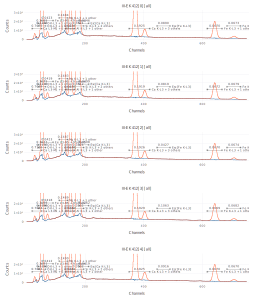

In [12]:
using CSV
CSV.write("$path/kratios.csv", df)
set_default_plot_size(10inch, 12inch)
vstack((r->plot(r,1:750)).(res))

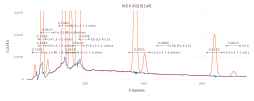

In [13]:
set_default_plot_size(10inch,4inch)
plot(res[1],1:750)

Using the statistics summary capabilities in <code>DataFrames</code> to produce a statistical summary of the k-ratio results.  The <code>true</code> argument to <code>convert(...)</code> adds fit uncertainties.

In [14]:
describe(asa(DataFrame, res, true), :mean, :std, :min, :q25, :median, :q75, :max)

23×8 DataFrame
│ Row │ variable               │ mean        │ std         │ min         │ q25         │ median      │ q75         │ max         │
│     │ Symbol                 │ Union…      │ Union…      │ Union…      │ Union…      │ Union…      │ Union…      │ Union…      │
├─────┼────────────────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ 1   │ Name                   │             │             │             │             │             │             │             │
│ 2   │ Al K-L3 + 1 other      │ 0.0678629   │ 0.000208351 │ 0.0675364   │ 0.0678145   │ 0.0679008   │ 0.0679746   │ 0.0680883   │
│ 3   │ U(Al K-L3 + 1 other)   │ 3.65407e-5  │ 7.82477e-8  │ 3.6459e-5   │ 3.64635e-5  │ 3.65537e-5  │ 3.6591e-5   │ 3.66364e-5  │
│ 4   │ Ca K-L3 + 3 others     │ 0.192483    │ 0.00033901  │ 0.191941    │ 0.192506    │ 0.192529    │ 0.192558    │ 0.19288     │
│ 5   │ U(Ca K-L3 + 3 others)  │ 4.90733e-5  │ 8.11334e-8  │ 4.89757e-5  │ 4.90105e-5  │ 4.90734e-5  │ 4.9152e-5   │ 4.9155e-5   │
│ 6   │ Ca L3-M1 + 6 others    │ 0.70821     │ 0.00309163  │ 0.703939    │ 0.707475    │ 0.708333    │ 0.708713    │ 0.712589    │
│ 7   │ U(Ca L3-M1 + 6 others) │ 0.00133006  │ 4.11986e-6  │ 0.00132417  │ 0.00132736  │ 0.00133204  │ 0.00133322  │ 0.00133352  │
│ 8   │ Ecs[Ca K-L3]           │ -0.0406668  │ 0.0104212   │ -0.0507582  │ -0.0498614  │ -0.0419199  │ -0.0346125  │ -0.0261822  │
│ 9   │ U(Ecs[Ca K-L3])        │ 0.0531011   │ 4.484e-5    │ 0.0530477   │ 0.0530804   │ 0.0531028   │ 0.0531046   │ 0.05317     │
│ 10  │ Ecs[Fe K-L3]           │ 0.0822879   │ 0.0238627   │ 0.0426568   │ 0.0819245   │ 0.0889949   │ 0.0915845   │ 0.106279    │
│ 11  │ U(Ecs[Fe K-L3])        │ 0.00494479  │ 1.63378e-5  │ 0.00492219  │ 0.00493764  │ 0.0049459   │ 0.00495222  │ 0.00496599  │
│ 12  │ Fe K-L3 + 1 other      │ 0.0670096   │ 9.67645e-5  │ 0.0669294   │ 0.0669501   │ 0.0669698   │ 0.0670295   │ 0.0671693   │
│ 13  │ U(Fe K-L3 + 1 other)   │ 2.98177e-5  │ 3.78152e-8  │ 2.97643e-5  │ 2.98019e-5  │ 2.98188e-5  │ 2.98392e-5  │ 2.98641e-5  │
│ 14  │ Fe K-M3 + 1 other      │ 0.0675457   │ 0.000478912 │ 0.0669926   │ 0.0672653   │ 0.0674227   │ 0.06785     │ 0.0681977   │
│ 15  │ U(Fe K-M3 + 1 other)   │ 0.000119212 │ 2.01355e-7  │ 0.000118943 │ 0.000119085 │ 0.000119281 │ 0.000119288 │ 0.000119463 │
│ 16  │ Fe L3-M5 + 9 others    │ 0.0419126   │ 0.000447013 │ 0.0412065   │ 0.0418374   │ 0.0419259   │ 0.0422936   │ 0.0422995   │
│ 17  │ U(Fe L3-M5 + 9 others) │ 0.00010653  │ 1.11002e-7  │ 0.000106348 │ 0.000106509 │ 0.000106568 │ 0.000106607 │ 0.000106621 │
│ 18  │ Mg K-L3 + 1 other      │ 0.148675    │ 0.000314988 │ 0.14831     │ 0.14839     │ 0.148735    │ 0.148917    │ 0.149022    │
│ 19  │ U(Mg K-L3 + 1 other)   │ 4.53234e-5  │ 8.54015e-8  │ 4.52291e-5  │ 4.52421e-5  │ 4.53346e-5  │ 4.54023e-5  │ 4.54089e-5  │
│ 20  │ O K-L3 + 1 other       │ 0.318136    │ 0.00134519  │ 0.316513    │ 0.317479    │ 0.317705    │ 0.319099    │ 0.319885    │
│ 21  │ U(O K-L3 + 1 other)    │ 0.000100165 │ 2.99014e-7  │ 9.98344e-5  │ 9.99341e-5  │ 0.000100111 │ 0.000100439 │ 0.000100507 │
│ 22  │ Si K-L3 + 2 others     │ 0.352424    │ 0.000816319 │ 0.351238    │ 0.352083    │ 0.352439    │ 0.353164    │ 0.353195    │
│ 23  │ U(Si K-L3 + 2 others)  │ 6.84775e-5  │ 1.33986e-7  │ 6.83202e-5  │ 6.8357e-5   │ 6.85025e-5  │ 6.86021e-5  │ 6.86056e-5  │

In [17]:
using Cairo
using Fontconfig
plot(unks,autoklms=true,xmax=8e3) |> PDF("foo.pdf")